<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/mtld%20%D0%B8%20hd%20%D0%B4%D0%BB%D1%8F%20%D0%BB%D0%B5%D0%BC%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lexicalrichness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lexicalrichness: filename=lexicalrichness-0.5.1-py3-none-any.whl size=15416 sha256=43a3026673d7ba18ef92ca72c2c742c14646fc4ae9d0d01d07a7c5c4162a013a
  Stored in directory: /root/.cache/pip/wheels/cd/ba/80/d4dabc1bf242a672ffc00226a2303a7471bb841c0872b2c212
Successfully built lexicalrichness


In [2]:
!pip install pandas openpyxl

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CEFR Level: A1, Avg HD-D: 0.7717
CEFR Level: A2, Avg HD-D: 0.8273
CEFR Level: B1, Avg HD-D: 0.8588
CEFR Level: B2, Avg HD-D: 0.8736
CEFR Level: A1, Avg MTLD: 56.8745
CEFR Level: A2, Avg MTLD: 84.8702
CEFR Level: B1, Avg MTLD: 117.7742
CEFR Level: B2, Avg MTLD: 146.3223


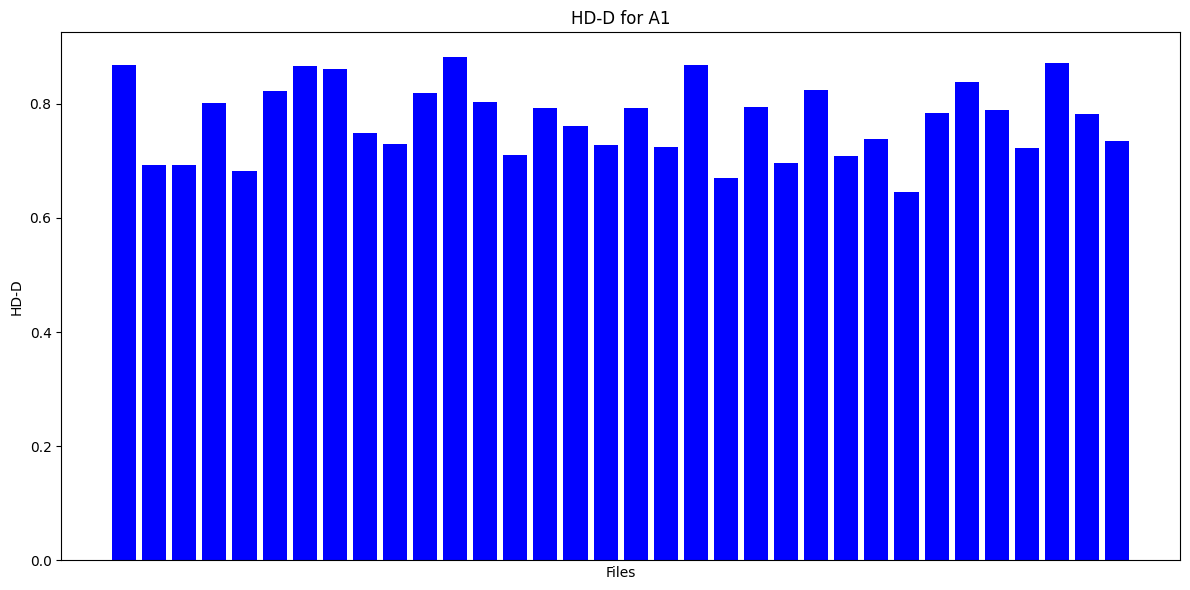

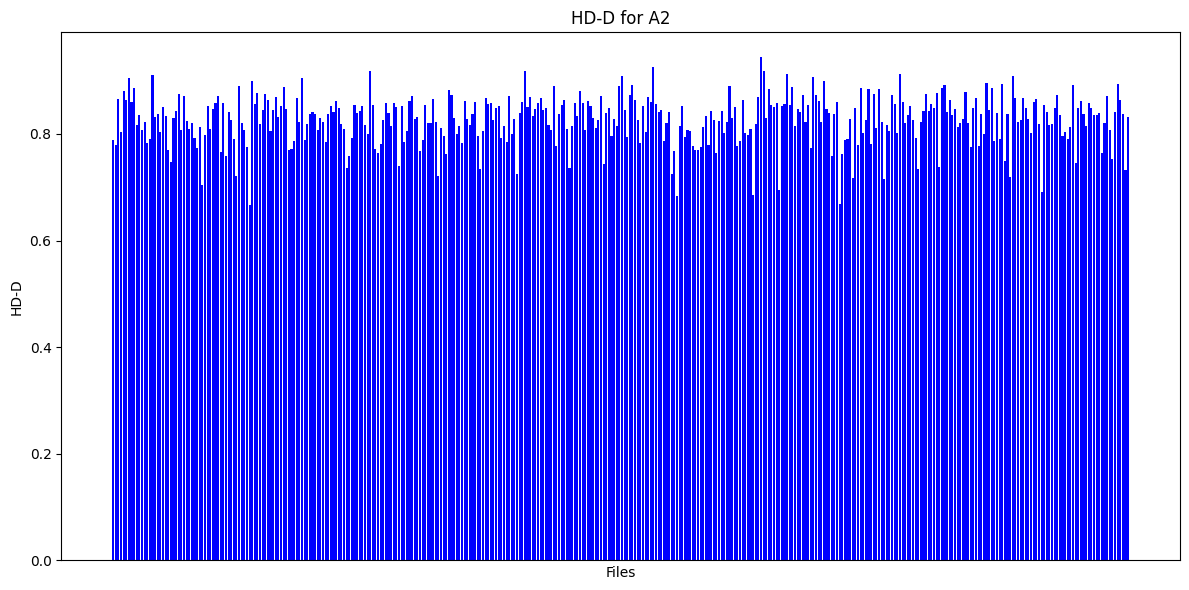

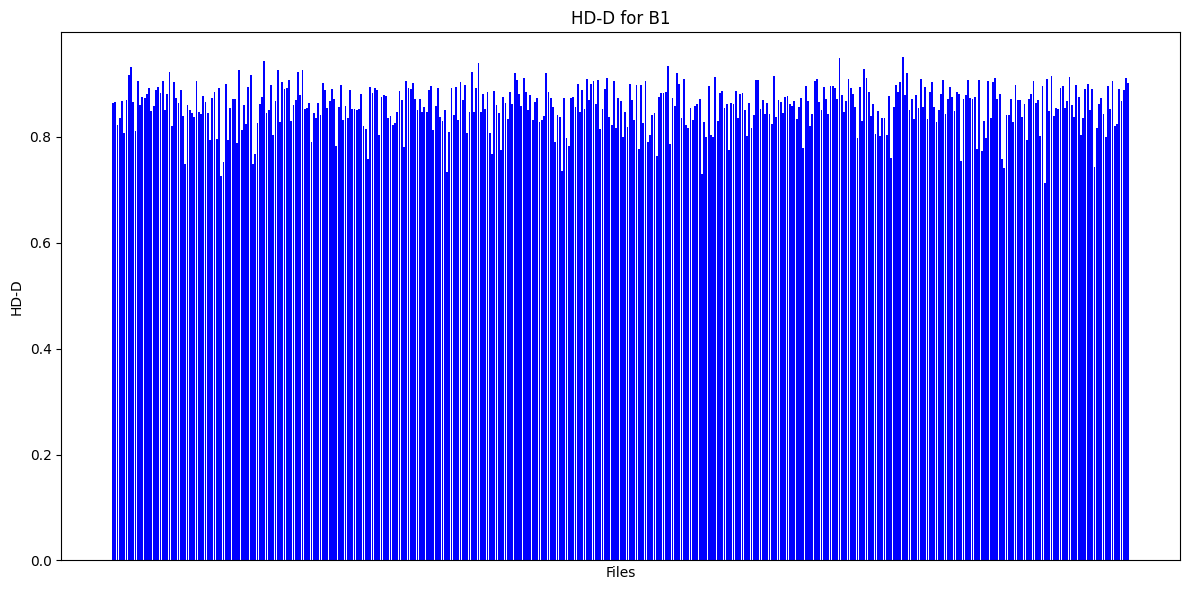

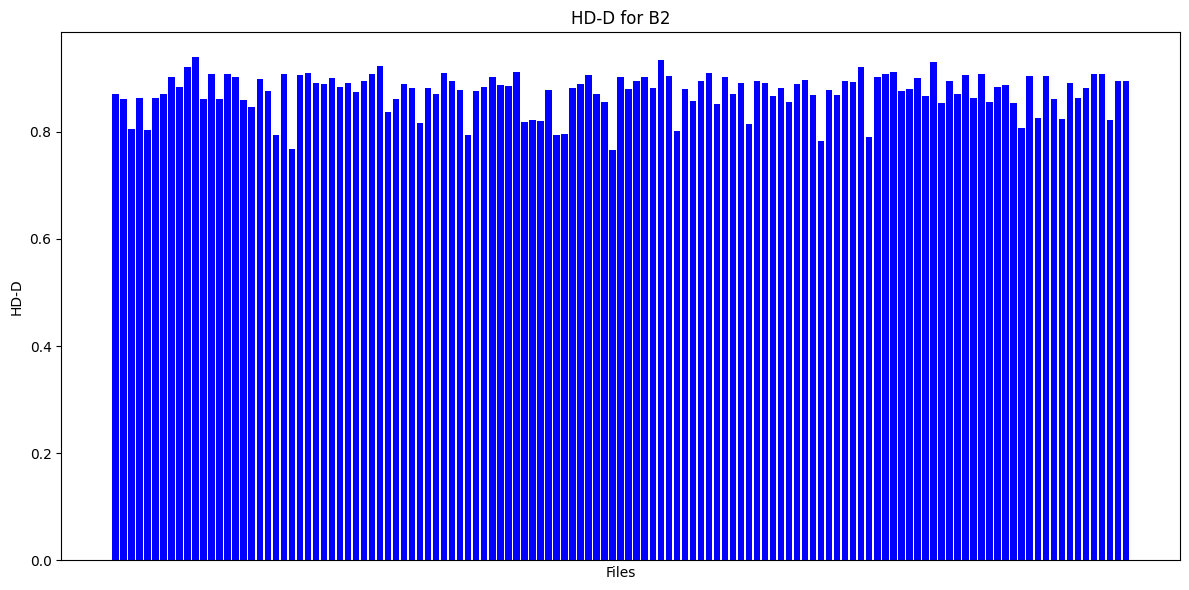

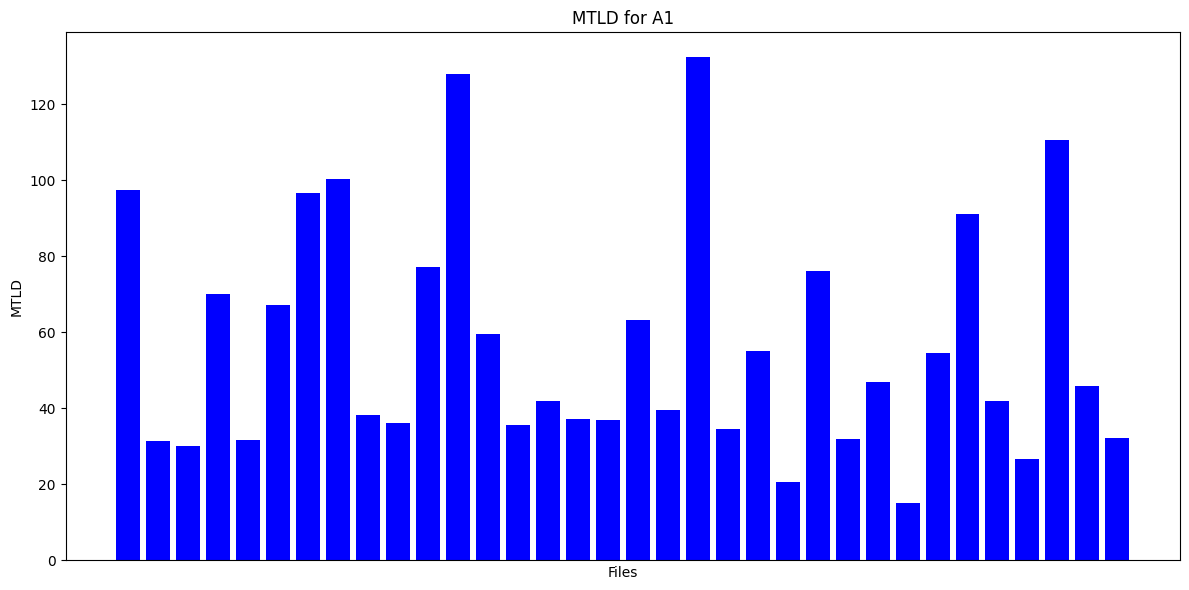

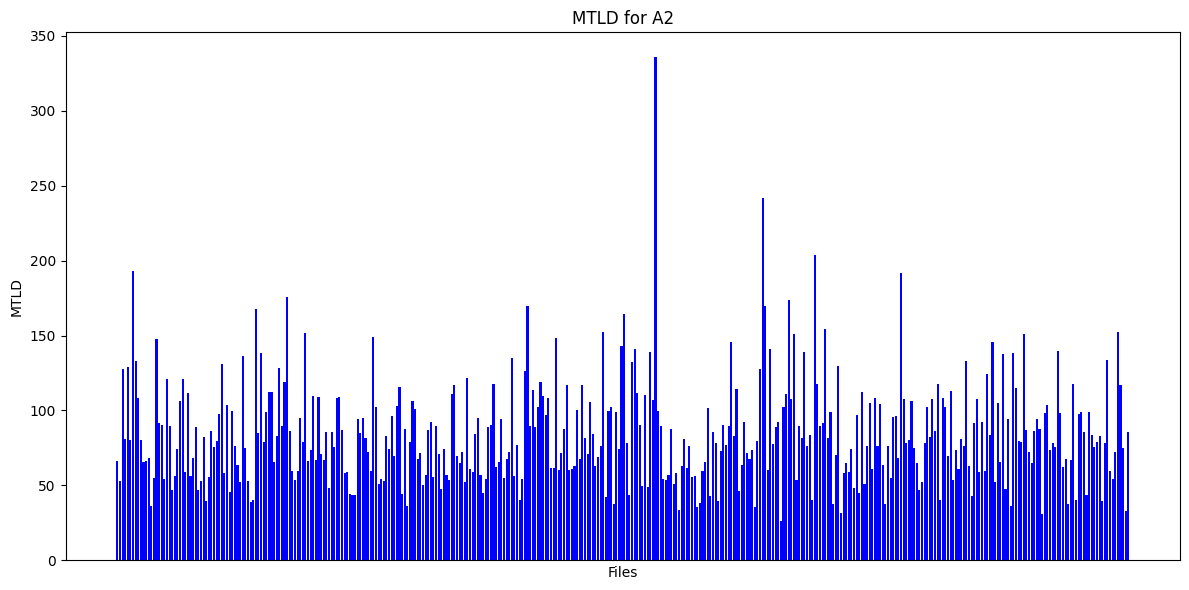

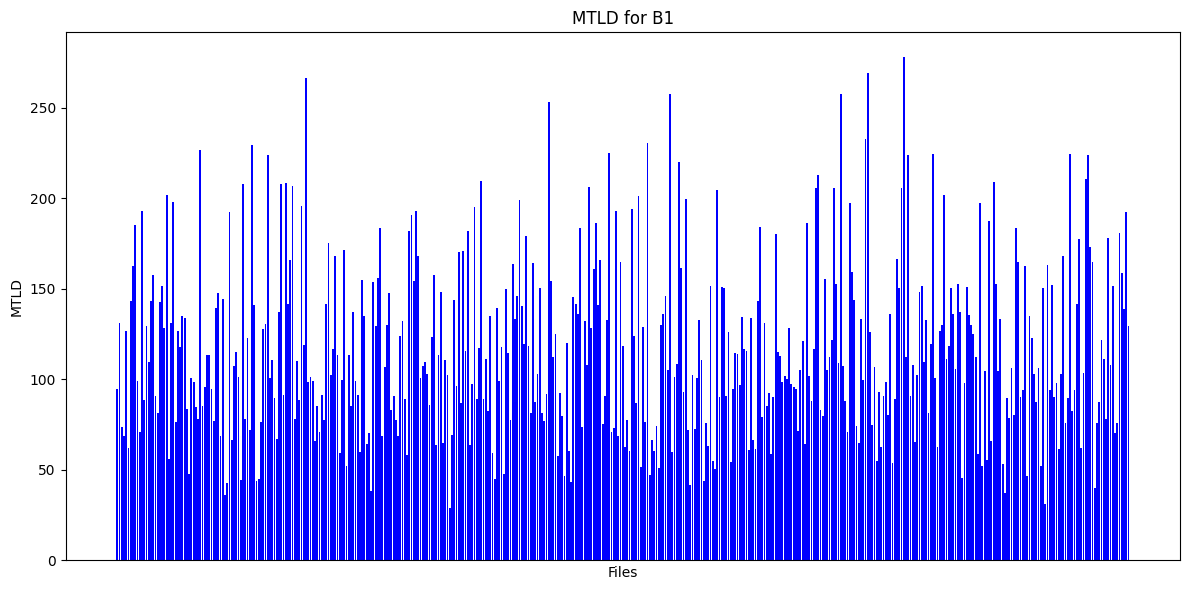

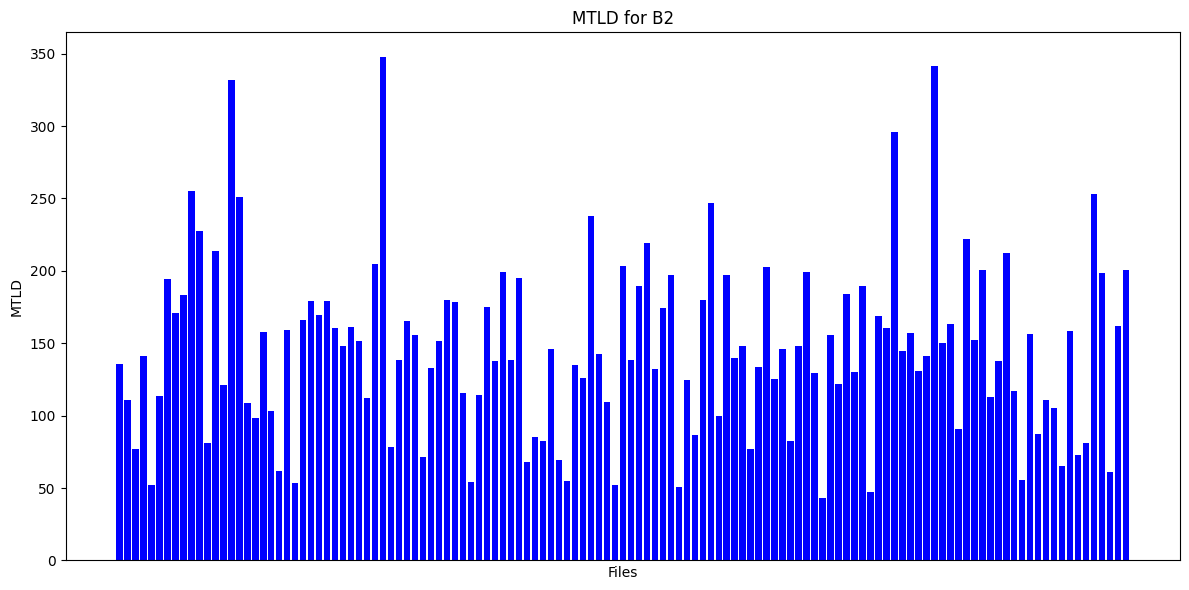

In [18]:
import os
import math
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from lexicalrichness import LexicalRichness

class MetricsCalculator:
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.hd_data = defaultdict(list)
        self.mtld_data = defaultdict(list)
        self.file_names = []

    def preprocess_text(self, text):
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\n', '', text)
        return text

    def calculate_ttr(self, lemmas):
        total_lemmas = len(lemmas)
        unique_lemmas = len(set(lemmas))
        ttr = unique_lemmas / total_lemmas
        return ttr

    def process_files(self, directory):
        cefr_levels = ['A1', 'A2', 'B1', 'B2']

        for cefr_level in cefr_levels:
            cefr_dir = os.path.join(directory, cefr_level)
            if os.path.isdir(cefr_dir):
                for filename in os.listdir(cefr_dir):
                    if filename.endswith(".txt"):
                        filepath = os.path.join(cefr_dir, filename)
                        with open(filepath, "r", encoding="utf-8") as file:
                            text = file.read()
                            preprocessed_text = self.preprocess_text(text)
                            tokens = word_tokenize(preprocessed_text)
                            lemmatizer = nltk.WordNetLemmatizer()
                            lemmas = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha()]
                            # Добавляем фильтрацию: игнорируем тексты с меньше чем 50 леммами
                            if len(lemmas) >= 50:
                                lex = LexicalRichness(text)
                                hd = lex.hdd(draws=42)
                                mtld = lex.mtld(threshold=0.72)
                                self.hd_data[cefr_level].append(hd)
                                self.mtld_data[cefr_level].append(mtld)
                                self.file_names.append(filename)

    def calculate_avg_metrics(self):
        avg_hd = {}
        avg_mtld = {}

        for cefr_level, hd_values in self.hd_data.items():
            avg_hd[cefr_level] = sum(hd_values) / len(hd_values)

        for cefr_level, mtld_values in self.mtld_data.items():
            avg_mtld[cefr_level] = sum(mtld_values) / len(mtld_values)

        return avg_hd, avg_mtld

    def save_to_excel(self, output_path):
        data = {
            'File Name': self.file_names,
            'CEFR Level': [],
            'HD-D': [],
            'MTLD': []
        }

        avg_hd, avg_mtld = self.calculate_avg_metrics()

        for cefr_level in avg_hd.keys():
            data['CEFR Level'].extend([cefr_level] * len(self.hd_data[cefr_level]))
            data['HD-D'].extend(self.hd_data[cefr_level])
            data['MTLD'].extend(self.mtld_data[cefr_level])

        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)

    def plot_metric(self, metric_data, title):
        for cefr_level, values in metric_data.items():
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(values)), values, color='b')
            plt.xticks([])
            plt.xlabel('Files')
            plt.ylabel(title)
            plt.title(f'{title} for {cefr_level}')
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    directory_path = "/content/Students_texts"
    output_excel_path = "/content/lexical_metrics.xlsx"

    metrics_calculator = MetricsCalculator(threshold=0.72)
    metrics_calculator.process_files(directory_path)

    avg_hd, avg_mtld = metrics_calculator.calculate_avg_metrics()

    for cefr_level, avg in avg_hd.items():
        print(f"CEFR Level: {cefr_level}, Avg HD-D: {avg:.4f}")

    for cefr_level, avg in avg_mtld.items():
        print(f"CEFR Level: {cefr_level}, Avg MTLD: {avg:.4f}")

    metrics_calculator.save_to_excel(output_excel_path)

    metrics_calculator.plot_metric(metrics_calculator.hd_data, 'HD-D')
    metrics_calculator.plot_metric(metrics_calculator.mtld_data, 'MTLD')